In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(0, '/Users/florianrunkel/Documents/02_Uni/04_Masterarbeit/masterthesis/')

from backend.ml_pipe.data.database.mongodb import MongoDb

# Matplotlib Einstellungen für deutsche Beschriftungen
plt.rcParams['font.size'] = 10
plt.style.use('default')

In [2]:
try:
    mongo_client = MongoDb()
    result = mongo_client.get_all('feedback')
    feedback_data = result.get('data', [])

    print(feedback_data)

except Exception as e:
    print(f"Error connecting to MongoDB: {e}")

[{'_id': '685bc74091c09c04f30dc82f', 'uid': 'UID001', 'freeText': '', 'prognoseBewertung': [{'modell': 'GRU', 'prognose': '30%', 'echt': '90%', 'differenz': '60%', 'bemerkung': 'hwxiwiqmywa'}], 'bewertungsskala': [2, 3, 4, 2, 4, 5], 'timestamp': '2025-06-25T09:54:08.654901Z'}, {'_id': '68812e8398cbf294905e8509', 'uid': 'UID006', 'freeText': 'Firmenzugehörigkeit höher als Position -> immer in selber Firma desto unwahrscheinlicher ein Wechsel\nFand das TFT Model am besten \nUnterschied der Modelle nicht klar ersichtlich ', 'prognoseBewertung': [{'modell': 'GRU', 'prognose': '4 - 6 Monate ', 'echt': 'mindestens noch 1 Jahr ', 'bemerkung': 'aktuell in der Probezeit'}], 'bewertungsskala': [1, 3, 4, 2, 4, 4], 'explanationFeedback': {'explanationHelpful': 'yes', 'featureImportanceUseful': 'no', 'lessTrustWithoutExplanation': 'yes'}, 'timestamp': '2025-07-23T18:48:35.050322Z'}, {'_id': '68826c1d7e9f378fb7971df4', 'uid': 'UID006', 'freeText': 'ich glaube, dass die App vor allem für Active Sourc

In [3]:
df = pd.DataFrame(feedback_data)
print(f"�� DataFrame erstellt mit {len(df)} Zeilen und {len(df.columns)} Spalten")
print(df.head())

# Timestamp in datetime konvertieren
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].dt.date
df['hour'] = df['timestamp'].dt.hour
df['weekday'] = df['timestamp'].dt.day_name()

# Bewertungsskala-Daten extrahieren
rating_criteria = [
    'Relevance and realism of predictions',
    'Transparency of model decisions',
    'Usefulness for daily work in Active Sourcing',
    'Trustworthiness of the AI recommendations',
    'Likelihood of future usage in real scenarios',
    'Overall impression and satisfaction'
]

# Bewertungen in separate Spalten aufteilen
for i, criterion in enumerate(rating_criteria):
    df[f'rating_{i+1}'] = df['bewertungsskala'].apply(lambda x: x[i] if isinstance(x, list) and len(x) > i else np.nan)


�� DataFrame erstellt mit 21 Zeilen und 7 Spalten
                        _id     uid  \
0  685bc74091c09c04f30dc82f  UID001   
1  68812e8398cbf294905e8509  UID006   
2  68826c1d7e9f378fb7971df4  UID006   
3  688b88af560380e772e252fa  UID006   
4  68922c52dffebd2cbcce1816  UID006   

                                            freeText  \
0                                                      
1  Firmenzugehörigkeit höher als Position -> imme...   
2  ich glaube, dass die App vor allem für Active ...   
3  Sehr gut, wenn ich mehrere Profile zur selben ...   
4  Bietet deutlichen Mehrwert, wenn XAI sehr gut ...   

                                   prognoseBewertung     bewertungsskala  \
0  [{'modell': 'GRU', 'prognose': '30%', 'echt': ...  [2, 3, 4, 2, 4, 5]   
1  [{'modell': 'GRU', 'prognose': '4 - 6 Monate '...  [1, 3, 4, 2, 4, 4]   
2  [{'modell': '', 'prognose': '', 'echt': '', 'b...  [3, 3, 3, 3, 3, 3]   
3  [{'modell': 'GRU', 'prognose': '7-9 Monate', '...  [5, 5, 5, 4, 4, 5]  

In [4]:
def extract_model_ratings(row):
    if isinstance(row, list):
        return [item.get('modell', '') for item in row if isinstance(item, dict)]
    return []

df['used_models'] = df['prognoseBewertung'].apply(extract_model_ratings)
df['model_count'] = df['used_models'].apply(len)

# Grundlegende Statistiken
print("\nFEEDBACK-DATA OVERVIEW")
print("=" * 50)
print(f"Total number of feedback: {len(df)}")  
print(f"Time period: {df['timestamp'].min().strftime('%d.%m.%Y')} - {df['timestamp'].max().strftime('%d.%m.%Y')}")


FEEDBACK-DATA OVERVIEW
Total number of feedback: 21
Time period: 25.06.2025 - 26.08.2025


In [5]:
print("\nBEWERTUNGSVERTEILUNG (1-5 Skala):")
for i, criterion in enumerate(rating_criteria):
    col = f'rating_{i+1}'
    if col in df.columns:
        ratings = df[col].dropna()
        if len(ratings) > 0:
            avg_rating = ratings.mean()
            print(f"  {criterion[:40]}: {avg_rating:.2f}/5.0 ({len(ratings)} ratings)")


BEWERTUNGSVERTEILUNG (1-5 Skala):
  Relevance and realism of predictions: 3.81/5.0 (21 ratings)
  Transparency of model decisions: 3.81/5.0 (21 ratings)
  Usefulness for daily work in Active Sour: 3.67/5.0 (21 ratings)
  Trustworthiness of the AI recommendation: 3.57/5.0 (21 ratings)
  Likelihood of future usage in real scena: 3.76/5.0 (21 ratings)
  Overall impression and satisfaction: 4.52/5.0 (21 ratings)


<Figure size 1200x800 with 0 Axes>

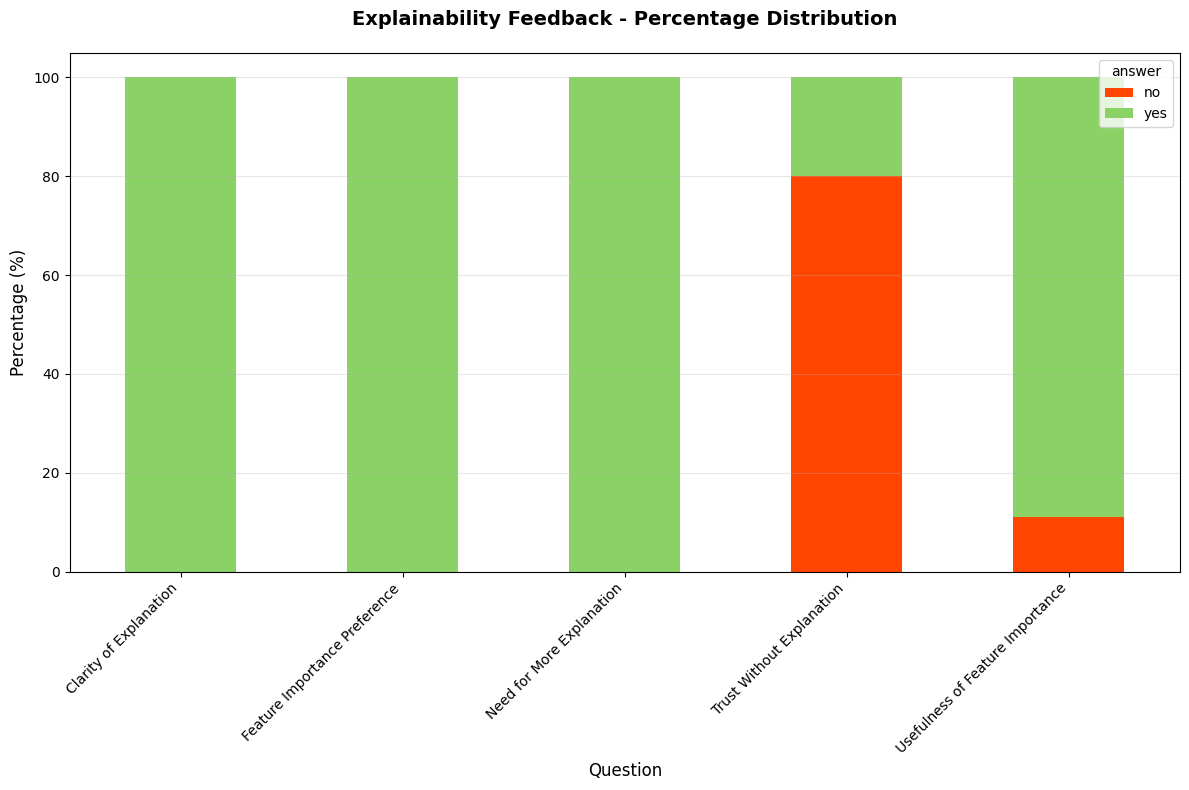

In [6]:
explanation_data = []
for _, row in df.iterrows():
    if isinstance(row['explanationFeedback'], dict):
        for key, value in row['explanationFeedback'].items():
            explanation_data.append({
                'question': key,
                'answer': value,
                'uid': row['uid']
            })

if explanation_data:
    explanation_df = pd.DataFrame(explanation_data)

    question_mapping = {
        'wantFeatureImportance': 'Feature Importance Preference',
        'wantMoreExplainability': 'Need for More Explanation',
        'explanationHelpful': 'Clarity of Explanation',
        'featureImportanceUseful': 'Usefulness of Feature Importance',
        'lessTrustWithoutExplanation': 'Trust Without Explanation',
    }

    explanation_df['question_label'] = explanation_df['question'].map(question_mapping)
    answer_counts = explanation_df.groupby(['question_label', 'answer']).size().unstack(fill_value=0)

    plt.figure(figsize=(12, 8))
    answer_percentages = answer_counts.div(answer_counts.sum(axis=1), axis=0) * 100

    answer_percentages.plot(kind='bar', stacked=True, 
                           color=['#FF4500', '#8AD265'], 
                           figsize=(12, 8))

    plt.title('Explainability Feedback - Percentage Distribution', 
              fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Question', fontsize=12)
    plt.ylabel('Percentage (%)', fontsize=12)  
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Keine Explainability Feedback-Daten verfügbar")

In [7]:
print(f"\nEMPFEHLUNGEN:")
recommendations = []

if 'rating_1' in df.columns:  # Relevance and realism of predictions
    relevance_rating = df['rating_1'].mean()
    if relevance_rating < 3.5:
        recommendations.append(f"Improve relevance and realism of predictions (currently: {relevance_rating:.2f}/5.0)")

if 'rating_2' in df.columns:  # Transparency
    transparency_rating = df['rating_2'].mean()
    if transparency_rating < 3.5:
        recommendations.append(f"Improve transparency of model decisions (currently: {transparency_rating:.2f}/5.0)")

if 'rating_3' in df.columns:  # Usefulness
    usefulness_rating = df['rating_3'].mean()
    if usefulness_rating < 3.5:
        recommendations.append(f"Improve usefulness for the workplace (currently: {usefulness_rating:.2f}/5.0)")

if 'rating_4' in df.columns:  # Trustworthiness
    trustworthiness_rating = df['rating_4'].mean()
    if trustworthiness_rating < 3.5:
        recommendations.append(f"Improve trust in AI recommendations (currently: {trustworthiness_rating:.2f}/5.0)")

if 'rating_5' in df.columns:  # Likelihood of future usage
    likelihood_rating = df['rating_5'].mean()
    if likelihood_rating < 3.5:
        recommendations.append(f"Improve likelihood of future usage (currently: {likelihood_rating:.2f}/5.0)")

if 'rating_6' in df.columns:  # Overall impression
    overall_rating = df['rating_6'].mean()
    if overall_rating < 3.5:
        recommendations.append(f"Improve overall rating (currently: {overall_rating:.2f}/5.0)")

if recommendations:
    for rec in recommendations:
        print(f"    {rec}")
else:
    print("All criteria meet the target value of 3.5/5.0")


EMPFEHLUNGEN:
All criteria meet the target value of 3.5/5.0
